
# 1. OpenAI VLM (GPT-4*) - Basics
This section demonstrates the basic usage of OpenAI's Vision Language Model (VLM) capabilities using GPT-4.
We will use the OpenAI API to analyze an image and provide detailed textual insights.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation 
- https://platform.openai.com/docs/guides/vision?lang=node
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=image 
- https://platform.openai.com/docs/api-reference/chat


In [1]:
import openai
from dotenv import load_dotenv  
import os
import base64
import json
import textwrap

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


load_dotenv()
#openAIclient = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
openAIclient = openai.OpenAI(api_key= os.getenv("OPENAI_API_KEY"))




TEXTMODEL = "gpt-4o-mini" 
IMGMODEL= "gpt-4o-mini" 

# Path to your image
img = "images/street_scene.jpg"

In [2]:
#basic call to gpt4 with prompt and image

completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What's in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                        #"detail": "low"
                    }
                },
            ],
        }
    ],
)


# Wrap the text to a specified width

response = str(completion.choices[0].message)
print(textwrap.fill(response, width=120))


ChatCompletionMessage(content="The image depicts a bustling urban scene. In the foreground, there's a park bench with
two people sitting on it—one reading a newspaper and the other looking at a book or tablet. Nearby, a young boy is
sitting on the ground, focused on his device, while a figure lies on the ground, seemingly unconscious. Around them,
various pedestrians are walking, and some vehicles are passing by. Pigeons are scattered on the ground, and the
background features tall buildings under a vibrant sky, suggesting a lively city atmosphere. There's also a musician
playing guitar and a cyclist passing through the crosswalk.", role='assistant', function_call=None, tool_calls=None,
refusal=None)



# 1.1 Structured Output
Here, we expand upon the VLM example to request structured outputs. This approach allows for extracting 
well-organized information from images in a machine-readable format, such as JSON.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=json


In [3]:
def promptLLM(prompt : str = None, sysprompt : str = None,  image : str = None, wantJson : bool = False, returnDict : bool = False):
    returnValue = ""
    messages = [{"role": "system", "content" : sysprompt}]
    modelToUse = TEXTMODEL
    #force it to be a json answer prompt
    #prompt = prompt if not wantJson else returnJSONAnswerPrompt(prompt)
    messages.append({"role": "user", "content": [{ 
        "type" : "text", 
        "text" : prompt 
    }]})
    if image is not None:
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url" : image}})
        modelToUse = IMGMODEL

    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            #max_tokens= 400,
            response_format={ "type": "json_object" },
            messages=messages,
            temperature=0,
            #n=1,
        )
    else :
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            messages=messages,
            temperature=0,
            #n=1,
        )
    returnValue = returnValue.choices[0].message.content
    if returnDict:
        return json.loads(returnValue)
    return returnValue

In [4]:
output = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [5]:
output

{'description': {'scene': 'A bustling urban street in a city, showcasing a mix of pedestrians, vehicles, and buildings.',
  'foreground': {'elements': [{'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'teen',
      'clothing': 'green jacket, shorts',
      'activity': 'using a smartphone'}},
    {'type': 'person',
     'action': 'lying down',
     'details': {'gender': 'male',
      'age': 'teen',
      'clothing': 'red hoodie',
      'position': 'on the ground'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'female',
      'age': 'young adult',
      'clothing': 'red top, blue jeans',
      'activity': 'reading a book'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'older',
      'clothing': 'suit',
      'activity': 'reading a newspaper'}},
    {'type': 'person',
     'action': 'walking',
     'details': {'gender': 'female',
      'age': 'young adult',
    

In [6]:
output["description"]["foreground"]

{'elements': [{'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'teen',
    'clothing': 'green jacket, shorts',
    'activity': 'using a smartphone'}},
  {'type': 'person',
   'action': 'lying down',
   'details': {'gender': 'male',
    'age': 'teen',
    'clothing': 'red hoodie',
    'position': 'on the ground'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'red top, blue jeans',
    'activity': 'reading a book'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'older',
    'clothing': 'suit',
    'activity': 'reading a newspaper'}},
  {'type': 'person',
   'action': 'walking',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'pink top, shorts',
    'activity': 'holding a smartphone'}},
  {'type': 'flower pot', 'details': {'flowers': 'geraniums'}},
  {'type': 'birds',
   'details': {'species': 'pigeons'


# JSON Schema for Controlled Structured Outputs
In this section, we define a JSON schema for a more controlled and specific output from the model. 
Using this schema, we can ensure the model adheres to predefined data types and structures while describing images.In this case we will provide an exmaple of json format answer, but ideally 
one could also do it via e.g. pydantic library.

Example: 
```
from typing import List, Literal
from pydantic import BaseModel, Field


class Person(BaseModel):
    position: str = Field(..., description="Position of the person in the environment, e.g., standing, sitting, etc.")
    age: int = Field(..., ge=0, description="Age of the person, must be a non-negative integer.")
    activity: str = Field(..., description="Activity the person is engaged in, e.g., reading, talking, etc.")
    gender: Literal["male", "female", "non-binary", "other", "prefer not to say"] = Field(
        ..., description="Gender of the person"
    )


class ImageExtraction(BaseModel):
    number_of_people: int = Field(..., ge=0, description="The total number of people in the environment.")
    atmosphere: str = Field(..., description="Description of the atmosphere, e.g., calm, lively, etc.")
    hour_of_the_day: int = Field(..., ge=0, le=23, description="The hour of the day in 24-hour format.")
    people: List[Person] = Field(..., description="List of people and their details.")

```

In [7]:
def promptLLM(prompt : str = None, sysprompt : str = None,  image : str = None, wantJson : bool = False, returnDict : bool = False):
    returnValue = ""
    messages = [{"role": "system", "content" : sysprompt}]
    modelToUse = TEXTMODEL
    #force it to be a json answer prompt
    #prompt = prompt if not wantJson else returnJSONAnswerPrompt(prompt)
    messages.append({"role": "user", "content": [{ 
        "type" : "text", 
        "text" : prompt 
    }]})
    if image is not None:
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url" : image}})
        modelToUse = IMGMODEL

    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            #max_tokens= 400,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "img_extract",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "numberOfPeople": {
                        "type": "integer",
                        "description": "The total number of people in the environment",
                        "minimum": 0
                        },
                        "atmosphere": {
                        "type": "string",
                        "description": "Description of the atmosphere, e.g., calm, lively, etc."
                        },
                        "hourOfTheDay": {
                        "type": "integer",
                        "description": "The hour of the day in 24-hour format",
                        "minimum": 0,
                        "maximum": 23
                        },
                        "people": {
                        "type": "array",
                        "description": "List of people and their details",
                        "items": {
                            "type": "object",
                            "properties": {
                            "position": {
                                "type": "string",
                                "description": "Position of the person in the environment, e.g., standing, sitting, etc."
                            },
                            "age": {
                                "type": "integer",
                                "description": "Age of the person",
                                "minimum": 0
                            },
                            "activity": {
                                "type": "string",
                                "description": "Activity the person is engaged in, e.g., reading, talking, etc."
                            },
                            "gender": {
                                "type": "string",
                                "description": "Gender of the person",
                                "enum": ["male", "female", "non-binary", "other", "prefer not to say"]
                            }
                            },
                            "required": ["position", "age", "activity", "gender"]
                        }
                        }
                    },
                    "required": ["numberOfPeople", "atmosphere", "hourOfTheDay", "people"]
                    }}},
            messages=messages,
            temperature=0,
            #n=1,
        )
    else :
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,
            messages=messages,
            temperature=0,
            #n=1,
        )
    returnValue = returnValue.choices[0].message.content
    if returnDict:
        return json.loads(returnValue)
    return returnValue

In [8]:
output_image_analysis = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [9]:
#alert service prompt 

alert_sys_prompt = " you are an experienced first aid paramedical"
alert_prompt= """Extract from the following scene analysis give to you in json format, 
if anyone might be in danger and if the Child Hospital or normal Hospital should be alerted. 
Give the a concise answer
The situation is given to you from this object: """ + str(output_image_analysis)


In [10]:
promptLLM(prompt = alert_prompt, sysprompt= alert_sys_prompt) 

'In this scene, the 15-year-old male who is lying down and appears to be unconscious or resting may be in danger. It is advisable to alert a normal hospital for potential medical assistance, as the situation does not specifically indicate a pediatric emergency.'

In [11]:
promptLLM(prompt = "Considering the image analysis given" +str(output_image_analysis)+ "give me back the coordinates of the 16-years old. If these are not available, infer them form the pic", sysprompt= alert_sys_prompt) 

'Based on the provided image analysis, there is no mention of a 16-year-old individual. The ages of the people listed are 12, 15, 20, 25, 28, 30, and 35. Since there is no 16-year-old present, I cannot provide coordinates for that age group.\n\nIf you need assistance with another aspect of the scenario or have further questions, feel free to ask!'

In [12]:
promptLLM(prompt =  "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.", sysprompt= alert_sys_prompt, image = encode_image(img)) 

"I'm unable to assist with that."


# 2. Google VLM (Gemini)
This section demonstrates the use of Google's Vision Language Model, Gemini. 
We explore basic text generation as well as its ability to analyze images and provide relevant outputs.

**Support Material**:
- https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing


In [13]:
%matplotlib inline
import os
from dotenv import load_dotenv  
import google.generativeai as genai
from PIL import Image

load_dotenv()
#genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)


Artificial intelligence (AI) doesn't work in a single, unified way. Instead, it encompasses a vast array of techniques and approaches, all aiming to create systems that can perform tasks that typically require human intelligence.  Here's a breakdown of some key concepts:

**1. Core Principles:**

* **Learning from Data:**  This is arguably the most crucial aspect.  AI systems learn patterns and insights from vast amounts of data.  Instead of being explicitly programmed with rules, they identify these patterns themselves.  This learning process is often iterative, meaning the AI continuously refines its understanding as it receives more data.

* **Representation and Reasoning:** AI systems need to represent information in a way they can understand and manipulate.  This might involve numerical representations, symbolic logic, or complex graphs.  Reasoning involves using this representation to draw inferences, make predictions, and solve problems.

* **Adaptation and Generalization:**  A 

In [15]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[694, 329, 961, 628]


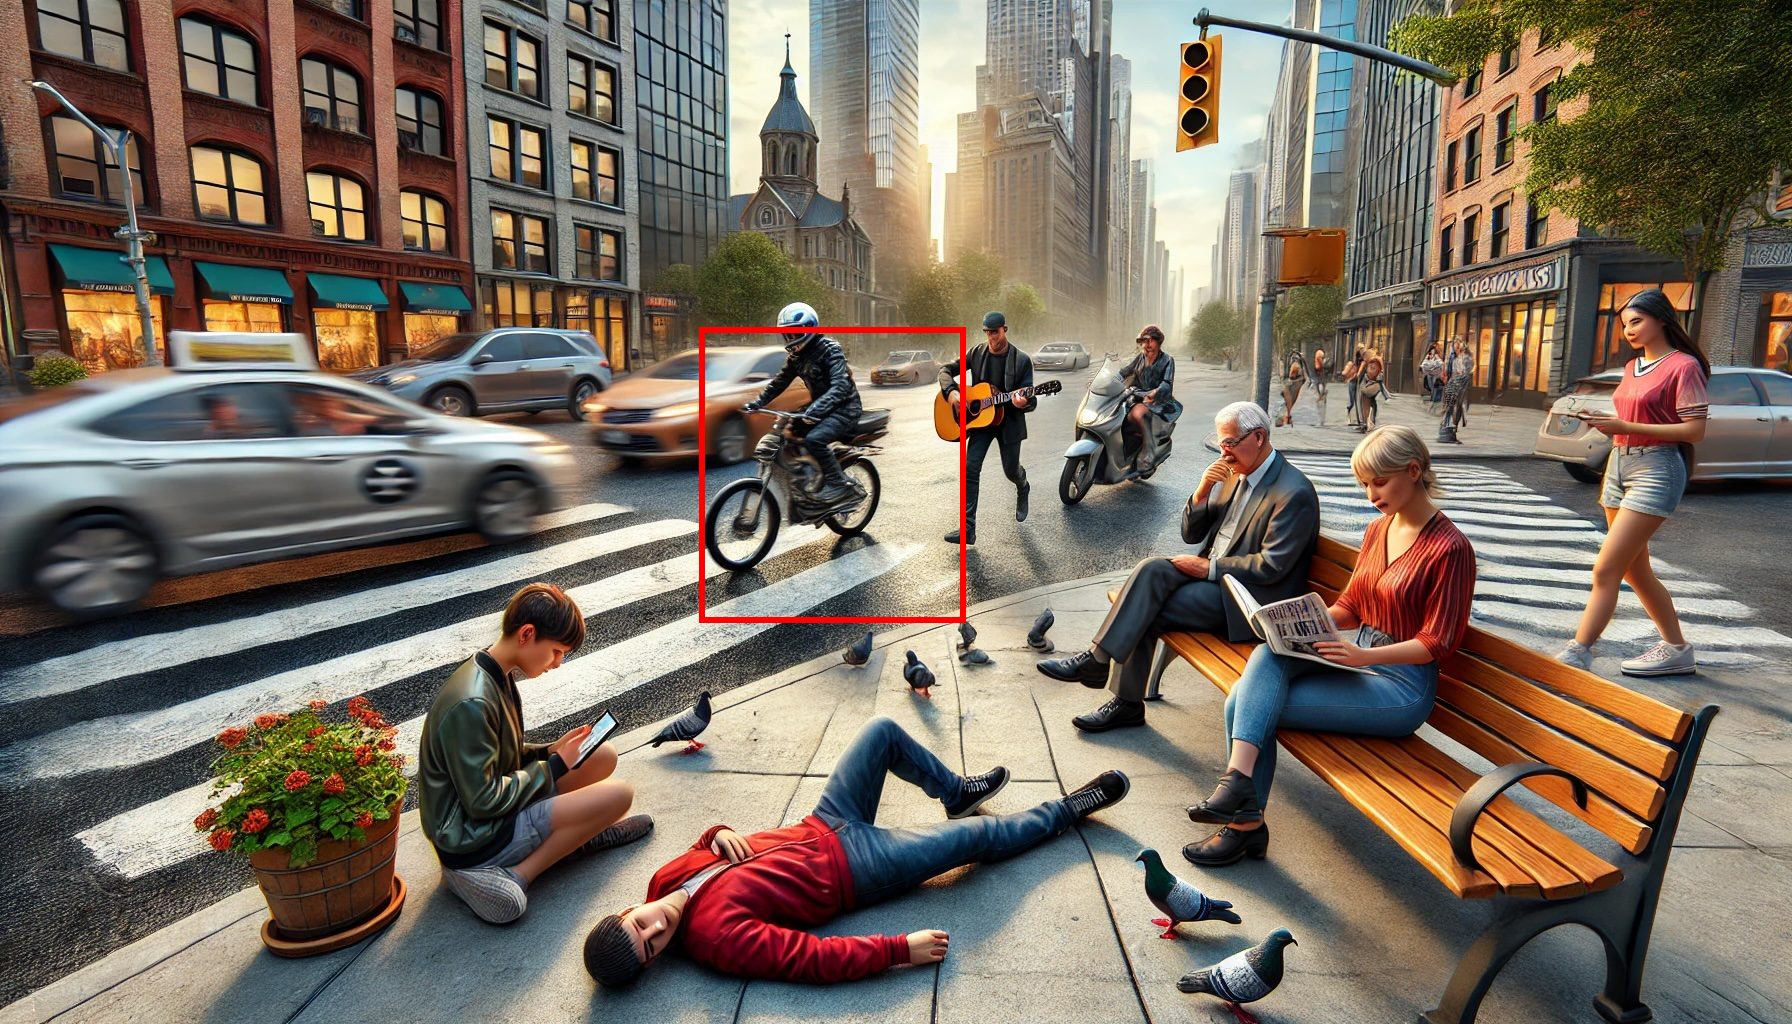

In [16]:
# KOORDINATEN AUF BILD ZEICHNEN

from PIL import ImageDraw

# Funktion zum Zeichnen einer Box auf dem Bild
def draw_box(image, coordinates, outline="red", width=6):
    draw = ImageDraw.Draw(image)
    draw.rectangle(coordinates, outline=outline, width=width)
    return image

# Beispielkoordinaten
coordinates = [699, 327, 965, 622]

# Bild öffnen
image = Image.open(img)

# Box zeichnen
image_with_box = draw_box(image, coordinates)

# Bild anzeigen
image_with_box.show()

Gemini can be used to predict bounding boxes based on free form text queries.
The model can be prompted to return the boxes in a variety of different formats (dictionary, list, etc). This of course migh need to be parsed. 
Check: https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=WFLDgSztv77H
